In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

Read the data and observe the distribution of missing values. The raw data has 28800 rows with many missing values. Each row has at most 39 missing values.

In [3]:
df = pd.read_csv('../data/train.csv')

df_tr, df_tt = train_test_split( df,  train_size= 0.8, random_state = 41, shuffle = True)

print(f"{df_tr.shape}\n")

print(f"{df_tt.shape}\n")


(23040, 60)

(5760, 60)



In [4]:
np.max(df_tr.isna().sum(axis=1))

np.int64(39)

From the histogram, we see most rows have at most 20 missing values.

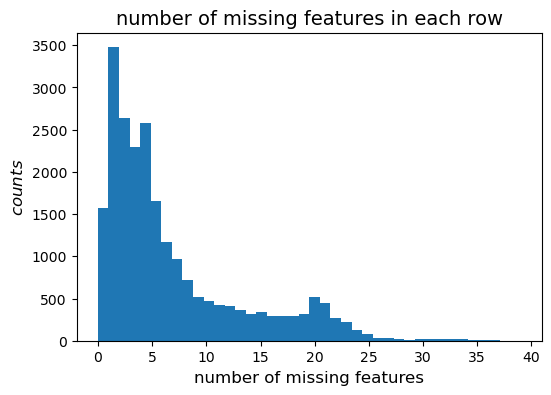

In [5]:

## Add a figsize here
plt.figure(figsize=(6,4))

## Fill in plt.plot
plt.hist(df_tr.isna().sum(axis=1).to_list(), bins=40)

## Give x and y labels
plt.xlabel("number of missing features", fontsize=12)
plt.ylabel("$counts$", fontsize=12)

## Give your plot a title
plt.title("number of missing features in each row", fontsize=14)

plt.show()

When dropping rows of data, one concern is that certain important features only appear in a subset of data, and one might lose those features after row dropping. We plot the distribution of "non-missing" values before dropping rows. 

In [11]:
df_tr.notna().sum().to_list()

[23040,
 22912,
 21367,
 16617,
 21308,
 19370,
 18404,
 23040,
 21247,
 20462,
 23040,
 22848,
 21482,
 21316,
 23040,
 18834,
 22538,
 17321,
 18893,
 14120,
 19699,
 20842,
 21307,
 20972,
 19703,
 23040,
 13510,
 19256,
 22563,
 23040,
 21602,
 9729,
 22862,
 7826,
 19607,
 21547,
 21585,
 21701,
 21024,
 21084,
 23040,
 21154,
 22867,
 21278,
 22830,
 19803,
 23040,
 22669,
 22334,
 21473,
 13905,
 22918,
 21907,
 20165,
 20981,
 20373,
 21384,
 19006,
 23040,
 23040]

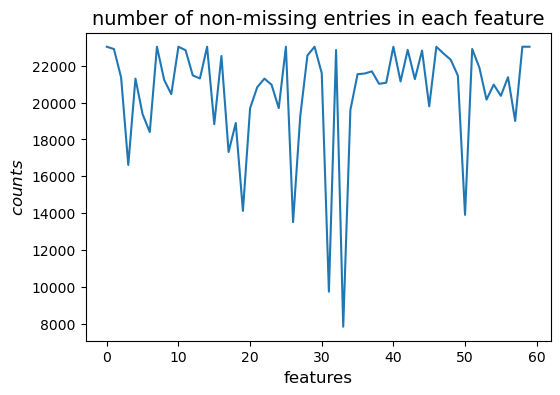

In [14]:
## Add a figsize here
plt.figure(figsize=(6,4))

## Fill in plt.plot
plt.plot(df_tr.notna().sum().to_list())

## Give x and y labels
plt.xlabel("features", fontsize=12)
plt.ylabel("$counts$", fontsize=12)

## Give your plot a title
plt.title("number of non-missing entries in each feature", fontsize=14)

plt.show()

In the following, we demonstrate the clean option "rdrop". This option drops rows which have strictly greater than params number of missing features. By setting params as 20, only less than 2000 number of rows are dropped.

In [15]:
import main_module as md

hct_df = md.hct("../data/train.csv")

hct_df.clean(method = "rdrop", params = 20)

hct_df.data.shape

main module is loaded
/Users/chew/Desktop/CIBMTR_post_hct_survival/scripts/main_module.py


(27029, 60)

In the following, we demonstrate one strategy to impute the data with a predictive model, using the column "dri_score" as an example. 
1. Seperate those rows with missing value in "dri_score" and those without missing values in "dri_score".
2. Get dummies for the categorical variables, and include NA as a category for each variables
3. Impute the numerical variables with a simple imputer
4. Train a logistic regression model using those rows without missing values in "dri_score" and predict.

In [5]:
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

df_na = df.loc[df["dri_score"].isna()].copy()

df_na_y = df_na["dri_score"]

df_na_X = df_na.drop(['ID', 'dri_score'], axis=1)

df_na_X = pd.get_dummies(df_na_X, dummy_na=True)

for key in df_na_X.keys():
    if df_na_X.dtypes[key] == float:
        imp = SimpleImputer(strategy="mean")
        df_na_X[[key]] = imp.fit_transform(df_na_X[[key]])

df_nonna = df.dropna(subset=["dri_score"]).copy()

df_nonna_y = df_nonna["dri_score"]

df_nonna_X = df_nonna.drop(['ID', 'dri_score'], axis=1)

df_nonna_X = pd.get_dummies(df_nonna_X, dummy_na=True)

for key in df_nonna_X.keys():
    if df_nonna_X.dtypes[key] == float:
        imp = SimpleImputer(strategy="mean")
        df_nonna_X[[key]] = imp.fit_transform(df_nonna_X[[key]])

regressor = LogisticRegression()

regressor.fit(df_nonna_X.loc[:, df_na_X.keys()], df_nonna_y)

df.loc[df_na_X.index.tolist(), "dri_score"] = regressor.predict(df_na_X.loc[:, df_na_X.keys()])
      


/opt/homebrew/Caskroom/miniforge/base/envs/erdos_spring_2025/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
